In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import re

In [2]:
# importing data

edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv')
hero_edges = pd.read_csv('hero-network.csv')
datasets = [edges, nodes, hero_edges]

In [3]:
# preprocessing
def strip_rightend(string):
    string = string.strip().rstrip('/')

    if string =='SPIDER-MAN/PETER PARKER':
        string = 'SPIDER-MAN/PETER PAR'
    elif string == 'SPIDER-MAN/PETER PARKERKER':
        string = 'SPIDER-MAN/PETER PAR'

    return string

In [4]:
for ds in datasets:
    ds.dropna(inplace=True)
    for col in ds.columns:
        ds[col] = ds[col].apply(lambda row: strip_rightend(row))

In [5]:
hero_edges_arr = np.array(hero_edges)
hero_edges_arr.shape

(574467, 2)

In [6]:
idx_self = np.where(hero_edges_arr[:,0] == hero_edges_arr[:,1])
idx_self
# we check on a sample
hero_edges.iloc[8889]

hero1    MISS AMERICA/MADELIN
hero2    MISS AMERICA/MADELIN
Name: 8889, dtype: object

In [7]:
hero_edges_arr = np.delete(hero_edges_arr, idx_self, axis = 0) # delete the self referring rows by their index
print(hero_edges_arr.shape) # 574467 down to 572235
heroes_df = pd.DataFrame(hero_edges_arr) # ! new df 
heroes_df.columns = ['hero1', 'hero2']

(572235, 2)


In [8]:
heroes = nx.from_pandas_edgelist(heroes_df, 'hero1', 'hero2', create_using=nx.Graph)

In [9]:
node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))

fl = np.power(np.array(list(map(float, node_count.values))), -1)

weights = dict( list(zip (node_count.index, fl) ) )

C:\Users\Admin\AppData\Local\Temp\ipykernel_5916\1918835698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))


In [10]:
node_tuple_weight = {}
for e in heroes.edges: # 
    try:
        weight = weights[(e[0], e[1])]
    except:
        weight = weights[(e[1], e[0])]

    node_tuple_weight[(e[0], e[1])] = weight

In [11]:
nx.set_edge_attributes(heroes, values = node_tuple_weight, name = 'weight')

In [12]:
node_data = list(zip(nodes.node, [{'tp':t}for t in nodes.type]))
edge_data = list(zip(edges.hero, edges.comic))

In [13]:
# modify edge data to be only included if nodes also in node_data

edge_arr = np.array(edge_data)
print(edge_arr.shape)
node_list = list(nodes.node)

tbd = []

for i in range(len(edge_arr)):
    a, b = edge_arr[i,0], edge_arr[i,1]
    if a not in node_list or b not in node_list:
        tbd.append(i)

edge_arr = np.delete(edge_arr, tbd, axis = 0)
print(edge_arr.shape)

edges_cleaned = pd.DataFrame(edge_arr)
edges_cleaned.columns = ['hero', 'comic'] # needed to establish top hero
# edge_data = [(e[0], e[1])for e in edge_arr.tolist()]
edge_data = list(zip(edges_cleaned.hero, edges_cleaned.comic))

(96104, 2)
(96104, 2)


In [14]:
comics = nx.Graph()
comics.add_nodes_from(node_data)
comics.add_edges_from(edge_data)

In [15]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby(by = 'hero')['comic'].size().sort_values(ascending=False)
top_n_heroes = np.array(list(zip(ls.index, ls.values)) )

- Functionality 4

In [16]:
#N: denoting the top N heroes that their data should be considered:

def Remove_Not_TopN(graph,N):
    #build the first part of the function to extract the nodes(heroes) that are not in the top N
    
    ls= edges.groupby(by = 'hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = (ls[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    subgraph=graph.copy()
    subgraph.remove_nodes_from(not_top_heroes) 
    return(subgraph)

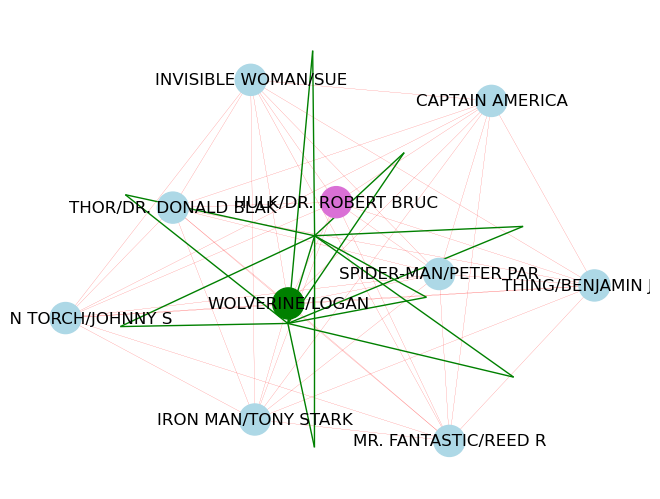

In [25]:
subgraph=Remove_Not_TopN(heroes,10)
# node colors
node_colors =['orchid' if node =='HULK/DR. ROBERT BRUC'  else 'green' if node == 'WOLVERINE/LOGAN'  else 'lightblue' for node in subgraph.nodes()]
nx.draw(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)



# Color the edges of node 'A' a different color
node_A_edges = [(u, v) for u, v, d in subgraph.edges(['WOLVERINE/LOGAN','HULK/DR. ROBERT BRUC'], data=True)]
nx.draw_networkx_edges(subgraph, pos=nx.spring_layout(subgraph), edgelist=node_A_edges, edge_color='green')


In [18]:
subgraph.nodes

NodeView(('IRON MAN/TONY STARK', 'HULK/DR. ROBERT BRUC', 'SPIDER-MAN/PETER PAR', 'CAPTAIN AMERICA', 'WOLVERINE/LOGAN', 'MR. FANTASTIC/REED R', 'THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE', 'THOR/DR. DONALD BLAK', 'HUMAN TORCH/JOHNNY S'))

To compute the minimum number of links in a graph to disconnect the graph into two disconnected subgraphs we can use a **minimum cut algorithm**. 
A minimum cut is a set of edges in the graph that, when removed, split the graph into two disconnected subgraphs (in our case each subgraph is related to one specific hero) . The minimum cut has the smallest possible total weight among all the cuts in the graph.



In [21]:
# Find the minimum number of links required to disconnect the graph into two subgraphs
min_cut_edges = nx.minimum_edge_cut(subgraph,'IRON MAN/TONY STARK', 'HULK/DR. ROBERT BRUC')
#print(min_cut_edges)
print(len(min_cut_edges))

9


In [22]:
# Extract the edges in the minimum cut
number_cut_edges=len(min_cut_edges)
subgraph.remove_edges_from(min_cut_edges)
# Print the minimum cut edges
#print(min_cut_edges)
print('• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is '+ str(number_cut_edges))
print('-Specifically, the removed edges are: '+ str(min_cut_edges))


• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9
-Specifically, the removed edges are: {('CAPTAIN AMERICA', 'HULK/DR. ROBERT BRUC'), ('THING/BENJAMIN J. GR', 'HULK/DR. ROBERT BRUC'), ('WOLVERINE/LOGAN', 'HULK/DR. ROBERT BRUC'), ('THOR/DR. DONALD BLAK', 'HULK/DR. ROBERT BRUC'), ('SPIDER-MAN/PETER PAR', 'HULK/DR. ROBERT BRUC'), ('MR. FANTASTIC/REED R', 'HULK/DR. ROBERT BRUC'), ('INVISIBLE WOMAN/SUE', 'HULK/DR. ROBERT BRUC'), ('IRON MAN/TONY STARK', 'HULK/DR. ROBERT BRUC'), ('HUMAN TORCH/JOHNNY S', 'HULK/DR. ROBERT BRUC')}


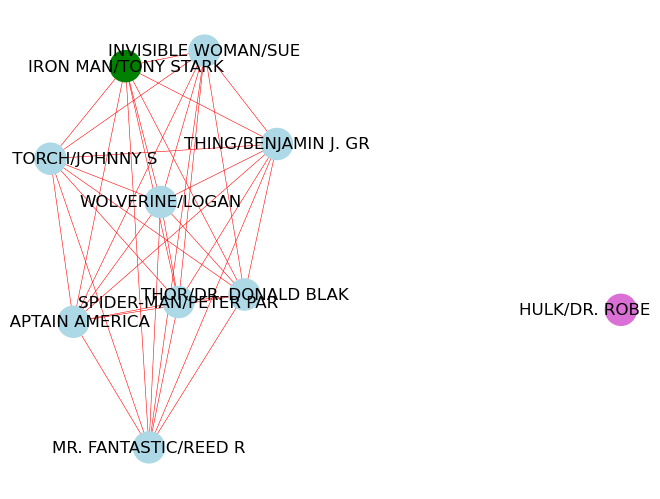

In [23]:
#subgraph.remove_edges_from(min_cut_edges)
node_colors =['orchid' if node =='HULK/DR. ROBERT BRUC'  else 'green' if node == 'IRON MAN/TONY STARK'  else 'lightblue' for node in subgraph.nodes()]
nx.draw(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.4, with_labels=True)

In [24]:
subgraph.degree('HULK/DR. ROBERT BRUC') #disconnected graph 

0

In [17]:
def functionality_4(graph_,heroA,heroB,N):
    #take the N hero of interest 
    graph=Remove_Not_TopN(heroes,10)
    # Find the minimum number of links required to disconnect the graph into two subgraphs
    min_cut_edges = nx.minimum_edge_cut(graph,'THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE' )
    print('• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is '+ str(len(min_cut_edges)))

In [18]:
functionality_4(heroes,'IRON MAN/TONY STARK','HULK/DR. ROBERT BRUC',10) #with 2 example nodes (heroes)

• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9








- Visualization 4

In [26]:
def visualization_4(graph_,heroA,heroB,N):
    #set plot dimension 
    plt.figure(figsize=(12, 6))
    
    #print original graph
    subgraph=Remove_Not_TopN(graph_,10)
    # node colors
    node_colors =['orchid' if node ==heroA  else 'green' if node == heroB  else 'lightblue' for node in subgraph.nodes()]
    plt.subplot(1, 2, 1)
    nx.draw_networkx(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)
    #print the minimum number of links required to disconnect the original graph in two disconnected subgraphs
    functionality_4(graph_,heroA,heroB,N)
    #remove the cutted edges
    min_cut_edges = nx.minimum_edge_cut(subgraph,heroA,heroB)
    subgraph.remove_edges_from(min_cut_edges)
    #print disconnected graph
    node_colors =['orchid' if node ==heroA  else 'green' if node == heroB  else 'lightblue' for node in subgraph.nodes()]
    plt.subplot(1, 2, 2)
    nx.draw_networkx(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)
    plt.suptitle('Strating Graphs and Disconnected Graph')
    
    plt.show()

• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9


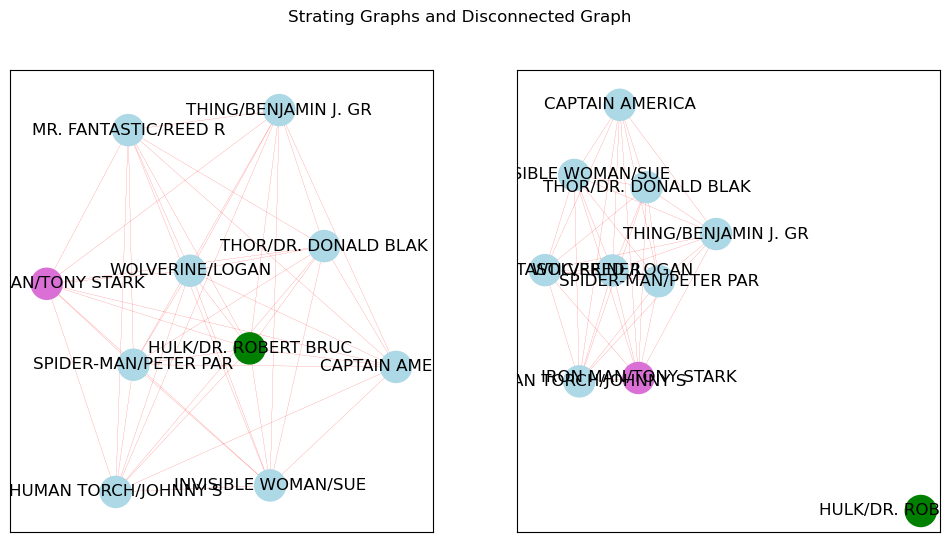

In [27]:
visualization_4(heroes,'IRON MAN/TONY STARK','HULK/DR. ROBERT BRUC',10)